# CNNs to Decode ECoG Data
Run the first few cells to normalize Local / Colab environments, then proceed below.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.cwd() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if not (Path.cwd() / 'repo').is_dir():
        # Download the workshop repo and change to its directory
        # For now edit the username/password. This requirement will be removed when the repo is made public.
        !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
    import tensorflow as tf
    !pip install git+https://github.com/bstriner/keras-tqdm.git --upgrade --no-deps
    !pip install plotly
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    # Clear any logs from previous notebooks
    if (Path.cwd() / 'logs').is_dir():
        import platform
        if platform.system() == 'Windows':
            !rmdir /S /Q logs
        else:
            !rm -Rf logs

# Additional imports
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import numpy as np
%load_ext tensorboard.notebook

logs\201905~1\train - The directory is not empty.
logs\201905~1\VALIDA~1 - The directory is not empty.


In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()
    print("Finished extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one participant
See 02_02 for an explanation.
However, this time we are loading the full-band time-domain data at the original sampling rate (1 kHz).
### Load the data
First define a helper function to load the data.

In [4]:
from sklearn.model_selection import train_test_split
from data.utils.fileio import from_neuropype_h5

# define a helper function to load the data
def load_faces_houses(sub_id):
    test_file = datadir / 'converted' / 'faces_basic' / (sub_id + '_full.h5')
    chunks = from_neuropype_h5(test_file)
    chunk_names = [_[0] for _ in chunks]
    chunk = chunks[chunk_names.index('signals')][1]
    ax_types = [_['type'] for _ in chunk['axes']]
    instance_axis = chunk['axes'][ax_types.index('instance')]
    n_trials = len(instance_axis['data'])
    X = chunk['data']
    Y = instance_axis['data']['Marker'].values.reshape(-1, 1)
    ax_info = {'instance_data': instance_axis['data'],
               'fs': chunk['axes'][ax_types.index('time')]['nominal_rate'],
               'timestamps': chunk['axes'][ax_types.index('time')]['times'],
               'channel_names': chunk['axes'][ax_types.index('space')]['names']
              }
    return X, Y, ax_info

Now load data from participant 'mv'.

In [5]:
# Load data from one participant.
SUB_ID = 'mv'
X, Y, ax_info = load_faces_houses(SUB_ID)
n_trials = X.shape[0]

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 603 trials, 801 timestamps (-0.2 to 0.6 at 1000 Hz), 58 channels


### Get baseline accuracy
Remember, the signals haven't been processed much. The only features we can expect LDA to pick out are stimulus-evoked time-domain signals. Also with 801 * 58 features, over-fitting is likely. Unfortunately, the LDA 'eigen' solver can't handle this ~600 x ~4800 matrix so we can't use its shrinkage. So we'll try regularized logistic regression instead. (Though it has 'regression' in the name, it's actually a classification algorithm).

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 200
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression.".format(N_SPLITS))
for trn, tst in splitter.split(X, Y):
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("3-class accuracy: {}".format(pcnt_corr))

3-class accuracy: 92.20563847429518


So even with way more features and without signal processing, we're getting fairly high accuracy at ~92%. Our goal is for the deep model to do at least as well, hopefully better, and we expect it will be useful in other ways too.

### Prepare data for deep learning
See 02_02 notebook for explanation.

In [6]:
def get_ds_train_valid(X, Y, p_train=0.8, batch_size=5):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_classes = len(classes)
    n_trials = len(y)
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        y_dat = tf.one_hot(tf.cast(y_dat, tf.uint8), n_classes)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=p_train)
    n_train = len(y_train)
    n_valid = len(y_valid)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    ds_train = ds_train.shuffle(int(n_trials * p_train) + 1).batch(batch_size, drop_remainder=True).repeat()  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size).repeat()
    
    return ds_train, ds_valid, n_train
    
PTRAIN = 0.8
BATCH_SIZE = 5
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=BATCH_SIZE)

## Create our model
As in 02_02, our model objective is to transform ECoG data into multiclass classification scores.
Let's start off with a model that someone else developed for similar purposes.

* [EEG with transfer learning](https://iopscience.iop.org/article/10.1088/1741-2552/aaf3f6)
* [ECoG speech reconstruction](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2018-102.pdf)
    * 2D CNN - channels x timestamps; amplitude data
* [ECoG CNNs with LSTMs](https://iopscience.iop.org/article/10.1088/1741-2552/aa9dbe/meta)
    1. CNN for spatial unmixing matrix [77] initialized with fast ICA
    1. 3 temporal CNN layers, with [2, 4, 8] filters of kernel size 1 x 17 per layer,
    initialized with biorthogonal wavelet 6.8.
* [ECoG CNNs with autoencoders](https://iopscience.iop.org/article/10.1088/1741-2552/aaf13f/pdf)


### The model is a series of blocks
The majority of our model -- everything except for the first and last layers -- is going to be composed of CNN layers and other utility layers. These layers are going to be present in a repeating pattern. The pattern will be 2-4 layers long, and we call the pattern a Block. Let's define the block first.

In [7]:
# Create a convenience function for adding a multilayer block
def cnn_block(block_inputs, n_filters=16, filter_length=8, activation='relu', pool_size=1, strides=None, dropout_rate=0.0):
    y_ = tf.keras.layers.Conv1D(n_filters, filter_length, activation=activation)(block_inputs)
    y_ = tf.keras.layers.BatchNormalization(momentum=0.9)(y_)
    if pool_size > 1:
        y_ = tf.keras.layers.MaxPooling1D(pool_size=pool_size, strides=strides)(y_)
    if dropout_rate > 0.0:
        y_ = tf.keras.layers.Dropout(rate=dropout_rate)(y_)
    return y_
# TODO: In many image-processing models, it's common to find 2 CNN layers in a row before maxpooling and dropout,
# and the first layer has `padding='same'`.

Each block has the following layers:
    * Conv1D
    * BatchNormalization
    * (optional) MaxPooling1D
    * (optional) Dropout

### Create and compile the model
We first define how many convolutional filters were going to have in N_FILTERS, and how long the filter kernel will be in FILTER_LENGTHS. Each of these variables has an entry for each block in the model.

The model starts with an `Input` layer and a `Dense` layer. These layers take inputs of different sizes (i.e., different numbers of channels) and transforms it into an input of N_SOURCES 'channels' or 'sources'. If we expect the output of the `Dense` layer to be approximately the same across patients with wildly different inputs, then we can think of the weights of this layer as a "spatial filter" or an "embedding" matrix, transforming sensor data into "source" data.

The last two layers simply flatten the activations into a single vector, then use a fully-connected layer to transform those into probabilities for each class.

In [18]:
N_FILTERS = [20, 40, 90, 100]
FILTER_LENGTHS = [18, 12, 8, 4]

# Define the input layers.
inputs = tf.keras.layers.Input(shape=X.shape[1:])
y_ = tf.keras.layers.Dense(64, activation='linear',
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)  # spat filt / embedding
# y_ = tf.keras.layers.Conv1D(64, 1)(inputs)  # Alternative way of doing spatial filtering?

# Build the middle of the model with the blocks.
for n_filts, filt_length in zip(N_FILTERS, FILTER_LENGTHS):
    y_ = cnn_block(y_, n_filters=n_filts, filter_length=filt_length, pool_size=3, dropout_rate=0.5)
    
# Add on the last layers to flatten and output our 3 class probabilities.
y_ = tf.keras.layers.Flatten()(y_)
y_ = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y_)
outputs = tf.keras.layers.Dense(3, activation='softmax')(y_)

# Instantiate, compile, print summary.
model = tf.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Save the weights for later
Wsave = model.get_weights()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 801, 58)]         0         
_________________________________________________________________
dense_3 (Dense)              (None, 801, 64)           3776      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 784, 20)           23060     
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 784, 20)           80        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 261, 20)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 261, 20)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 40)           9640

### Train the model
First prepare some callbacks that will be called at the completion of each training epoch so that we may monitor progress and 
inspect model performance.

In [19]:
# Prepare callbacks
import shutil
log_dir = Path.cwd() / "logs"
if log_dir.is_dir():
    try:
        shutil.rmtree(str(log_dir))
    except PermissionError:
        print("Unable to remove logs directory.")
log_dir = log_dir / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(str(log_dir), histogram_freq=1)

from keras_tqdm import TQDMNotebookCallback
tqdm_cb = TQDMNotebookCallback(leave_inner=True, leave_outer=True)
# The TQDMNotebookCallback does not implement all of the functions that tf.keras expects,
# so we simply create do-nothing functions as a workaround.
setattr(tqdm_cb, 'on_train_batch_begin', lambda x,y:None)
setattr(tqdm_cb, 'on_train_batch_end', lambda x,y:None)
setattr(tqdm_cb, 'on_test_begin', lambda x:None)
setattr(tqdm_cb, 'on_test_batch_begin', lambda x,y:None)
setattr(tqdm_cb, 'on_test_batch_end', lambda x,y:None)
setattr(tqdm_cb, 'on_test_end', lambda x:None)

Unable to remove logs directory.


Finally, train the model.
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [20]:
# Train model
N_EPOCHS = 100
history = model.fit(x=ds_train,  
                    epochs=N_EPOCHS, 
                    validation_data=ds_valid,
                    steps_per_epoch=n_train // BATCH_SIZE,
                    validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                    callbacks=[tensorboard_cb, tqdm_cb],
                    verbose=0)
print("Maximum validation accuracy: {:.2f}%".format(100*np.max(history.history['val_accuracy'])))

W0527 23:50:26.971831  7308 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.108643). Check your callbacks.



Maximum validation accuracy: 96.67%


In [21]:
model.save(datadir / 'converted' / 'faces_basic' / (SUB_ID + '_model_full.h5'))

In [31]:
%tensorboard --logdir={'logs/' + str(Path(log_dir).stem)}
# This doesn't run reliably on windows. Still not sure how to fix it.
# Run it once, wait a minute, then run it again.

Reusing TensorBoard on port 6006 (pid 1320), started -1 day, 23:05:50 ago. (Use '!kill 1320' to kill it.)

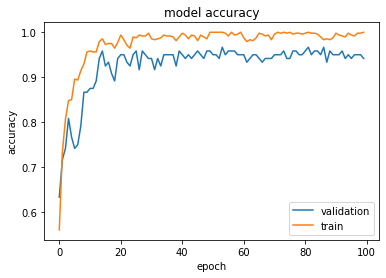

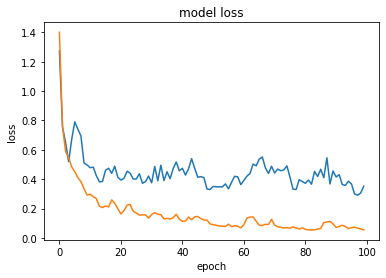

In [22]:
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='train')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)

### Spatial filter / embedding matrix
Let's visualize the first layer weights that transform the
input channel space into the 64-channel space.

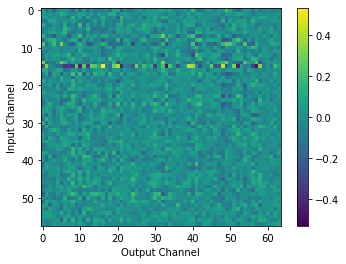

In [25]:
spatial_filter = model.layers[1].get_weights()[0]
plt.imshow(spatial_filter, vmax=abs(spatial_filter).max(), vmin=-abs(spatial_filter).max())
plt.xlabel('Output Channel')
plt.ylabel('Input Channel')
plt.colorbar()
plt.show()

It looks like there are only a few channels in the 8-15 range that have the most weight.
If we look at the names of the channels with the greatest weights we see some familiar
brain regions that we might expect to be involved in faces and/or houses processing,
whereas the channels with the lowest weights weren't even worthy of being labeled by the original researchers.

In [26]:
ch_ids = np.argsort(-np.sum(np.abs(spatial_filter), axis=1))
print("Top weighted channels: {}".format(ax_info['channel_names'][ch_ids[:3]]))
print("Least weighted channels: {}".format(ax_info['channel_names'][ch_ids[-3:]]))

Top weighted channels: ['Fusiform Gyrus.2' 'Fusiform Gyrus.0' 'Lingual Gyrus.3']
Least weighted channels: ['Non-Included Area.0' 'Non-Included Area.17' 'Parahippocampal Gyrus.1']


### First convolutional layer
The first convolutional layer is operating on time-domain data so it's still relatively simple. It can be interpreted simply by plotting its weights.

The plot is going to be dense, so we use plotly to give us an interactive plot. Start by configuring the figure, then in the following cell we actually plot the data.

In [27]:
from plotly.tools import make_subplots
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
plotly_cfg = dict(editable=True, scrollZoom=False, showLink=False,
                  displaylogo=False, autosizable=True, fillFrame=False,
                  modeBarButtonsToRemove=['sendDataToCloud'],
                  queueLength=10)
init_notebook_mode(connected=True)
fig = make_subplots(print_grid=False)
fig['layout'].update({'width': 800, 'height': 800, 'showlegend': False,
                      'xaxis': {'ticks': '', 'showticklabels': False, 'title': 'Filters'},
                      'yaxis': {'ticks': '', 'showticklabels': False, 'title': 'Input Sources'}})

Layout({
    'height': 800,
    'showlegend': False,
    'width': 800,
    'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'showticklabels': False, 'ticks': '', 'title': {'text': 'Filters'}},
    'yaxis': {'anchor': 'x',
              'domain': [0.0, 1.0],
              'showticklabels': False,
              'ticks': '',
              'title': {'text': 'Input Sources'}}
})

In [28]:
filters, biases = model.layers[2].get_weights()
# filters is shape 18 (kernel length), 64 (input sources), 20 (filters)
l_kernel, n_sources, n_filters = filters.shape
# For visualization, scale the filters to be between 0 and 1.
filters = np.copy(filters)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

for filt_ix in range(n_filters):
    x = np.arange(l_kernel) + filt_ix * l_kernel
    for in_ix in range(n_sources):
        fig.add_trace(go.Scatter(x=x, y=filters[:, in_ix, filt_ix] - in_ix,
                                 mode='lines', line={'color': 'black'},
                                 hoverinfo='skip', name=''))

iplot(fig, config=plotly_cfg)

### Maximum activations
For the remaining layers, it's difficult to conceptualize what data they represent simply by looking at their weights.
A more useful representation is to visualize an input that would maximize activation of a given filter.

[Source 1](https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py)
[Source 2](https://stackoverflow.com/questions/54195973/how-to-most-effectively-visualize-1d-convolutions)

In [29]:
import tempfile
from tensorflow.keras.models import load_model
model = load_model(str(datadir / 'converted' / 'faces_basic' / (SUB_ID + '_model_full.h5')))
layer_idx = -1
model.layers[layer_idx].activation = tf.keras.activations.linear
# Save and load the model to actually apply the change.
tmp_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + '.h5')
try:
    model.save(tmp_path)
    model = load_model(tmp_path)
finally:
    os.remove(tmp_path)

In [32]:
from indl.cnn_helper_1D import visualize_layer

layer_idx = 14
visualize_layer(model, model.layers[layer_idx].name, output_dim=(X.shape[1],))

TypeError: list indices must be integers or slices, not str

# Transfer Learning
* Freeze layers, update only first layer, then unfreeze and update

In [11]:
#Reset the model weights to what they were before training
model.set_weights(Wsave)

def replace_input_layers(old_model, new_input_shape):
    inputs = tf.keras.layers.Input(shape=new_input_shape)
    _y = tf.keras.layers.Dense(64, activation='linear')(inputs)  # spat filt
    for layer_ix, layer in enumerate(old_model.layers):
        if layer_ix > 1:
            _y = layer(_y)
    return tf.keras.Model(inputs, _y)

# Choose another participant, replace the input layers to match new input size, and retrain the model.
X, Y, ax_info = load_faces_houses('de')
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=BATCH_SIZE)
xfer_model = replace_input_layers(model, X.shape[1:])
xfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
xfer_model.summary()

N_EPOCHS = 20
history = xfer_model.fit(x=ds_train,  
                     epochs=N_EPOCHS, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 801, 31)]         0         
_________________________________________________________________
dense_2 (Dense)              (None, 801, 64)           2048      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 801, 64)           256       
_________________________________________________________________
conv1d (Conv1D)              (None, 790, 64)           49216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 263, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 263, 64)           0         
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 263, 64)           256 

96/96 [==============================] - ETA: 4s - loss: 0.0209 - accuracy: 1.00 - ETA: 1s - loss: 0.0916 - accuracy: 0.96 - ETA: 1s - loss: 0.2244 - accuracy: 0.86 - ETA: 1s - loss: 0.2395 - accuracy: 0.87 - ETA: 1s - loss: 0.2298 - accuracy: 0.88 - ETA: 1s - loss: 0.2334 - accuracy: 0.88 - ETA: 1s - loss: 0.2324 - accuracy: 0.89 - ETA: 0s - loss: 0.2227 - accuracy: 0.90 - ETA: 0s - loss: 0.2293 - accuracy: 0.90 - ETA: 0s - loss: 0.2390 - accuracy: 0.90 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.89 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - ETA: 0s - loss: 0.2316 - accuracy: 0.89 - ETA: 0s - loss: 0.2219 - accuracy: 0.90 - ETA: 0s - loss: 0.2342 - accuracy: 0.89 - ETA: 0s - loss: 0.2315 - accuracy: 0.89 - ETA: 0s - loss: 0.2357 - accuracy: 0.89 - ETA: 0s - loss: 0.2262 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.90 - ETA: 0s - loss: 0.2256 - accuracy: 0.90 - ETA: 0s - loss: 0.2201 - accuracy: 0.90 - ETA: 0s - loss: 0.2208 - accuracy: 

In [17]:
# Iterate through each participant
participant_names = ['ja', 'ca', 'wc', 'de', 'zt', 'fp']  # , 'mv'

input_hists = []
full_hists = []

for p_ix, p_name in enumerate(participant_names):
    
    # Load their data
    X, Y, ax_info = load_faces_houses(p_name)
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=20)
    
    # Make a new model with the proper input size
    xfer_model = replace_input_layers(xfer_model, X.shape[1:])
    
    # But first we'll freeze layers other than input layers.
    for layer_ix, layer in enumerate(xfer_model.layers):
        if layer_ix > 1:
            layer.trainable=False
    
    # Train for a couple epochs to update input layers only
    xfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    temp = xfer_model.fit(x=ds_train,  
                     epochs=10, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)
    input_hists.append(temp)
    
    # Unfreeze later layers
    for layer_ix, layer in enumerate(xfer_model.layers):
        if layer_ix > 1:
            layer.trainable=True
    
    # Train for longer at a much lower rate
    xfer_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])
    temp = xfer_model.fit(x=ds_train,  
                     epochs=N_EPOCHS, 
                     validation_data=ds_valid,
                     steps_per_epoch=n_train // BATCH_SIZE,
                     validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                     verbose=1)
    full_hists.append(temp)

# Save the weights for later
W_Xfer = xfer_model.get_weights()
xfer_model.save('xfer_model.h5')

Epoch 1/10
94/94 [==============================] - ETA: 17:40 - loss: 8.0613 - accuracy: 0.600 - ETA: 2:47 - loss: 7.7407 - accuracy: 0.433 - ETA: 1:26 - loss: 7.2823 - accuracy: 0.40 - ETA: 56s - loss: 6.3286 - accuracy: 0.4250 - ETA: 38s - loss: 5.5770 - accuracy: 0.454 - ETA: 28s - loss: 5.3938 - accuracy: 0.437 - ETA: 21s - loss: 4.9887 - accuracy: 0.490 - ETA: 17s - loss: 4.5898 - accuracy: 0.510 - ETA: 13s - loss: 4.2742 - accuracy: 0.522 - ETA: 10s - loss: 4.0892 - accuracy: 0.538 - ETA: 8s - loss: 3.7975 - accuracy: 0.552 - ETA: 6s - loss: 3.5697 - accuracy: 0.57 - ETA: 5s - loss: 3.4910 - accuracy: 0.56 - ETA: 3s - loss: 3.4127 - accuracy: 0.56 - ETA: 2s - loss: 3.2199 - accuracy: 0.57 - ETA: 1s - loss: 3.1124 - accuracy: 0.58 - ETA: 0s - loss: 3.0052 - accuracy: 0.59 - 13s 139ms/step - loss: 2.9097 - accuracy: 0.6000 - val_loss: 0.8805 - val_accuracy: 0.6783
Epoch 2/10
94/94 [==============================] - ETA: 9s - loss: 1.8695 - accuracy: 0.40 - ETA: 2s - loss: 0.9243 -

Epoch 1/20
94/94 [==============================] - ETA: 23:01 - loss: 0.0184 - accuracy: 1.000 - ETA: 5:35 - loss: 0.0859 - accuracy: 0.950 - ETA: 2:40 - loss: 0.1803 - accuracy: 0.87 - ETA: 1:42 - loss: 0.2845 - accuracy: 0.85 - ETA: 1:13 - loss: 0.2314 - accuracy: 0.87 - ETA: 56s - loss: 0.2099 - accuracy: 0.8900 - ETA: 44s - loss: 0.2120 - accuracy: 0.883 - ETA: 35s - loss: 0.2658 - accuracy: 0.864 - ETA: 29s - loss: 0.2458 - accuracy: 0.881 - ETA: 24s - loss: 0.2336 - accuracy: 0.883 - ETA: 20s - loss: 0.2334 - accuracy: 0.885 - ETA: 17s - loss: 0.2438 - accuracy: 0.877 - ETA: 14s - loss: 0.2448 - accuracy: 0.879 - ETA: 12s - loss: 0.2328 - accuracy: 0.884 - ETA: 10s - loss: 0.2325 - accuracy: 0.889 - ETA: 8s - loss: 0.2269 - accuracy: 0.893 - ETA: 7s - loss: 0.2579 - accuracy: 0.88 - ETA: 6s - loss: 0.2695 - accuracy: 0.88 - ETA: 4s - loss: 0.2608 - accuracy: 0.88 - ETA: 3s - loss: 0.2699 - accuracy: 0.88 - ETA: 2s - loss: 0.2842 - accuracy: 0.88 - ETA: 1s - loss: 0.2732 - accura

94/94 [==============================] - ETA: 7s - loss: 7.6624e-04 - accuracy: 1.00 - ETA: 3s - loss: 0.0272 - accuracy: 1.0000   - ETA: 2s - loss: 0.0525 - accuracy: 0.97 - ETA: 1s - loss: 0.0490 - accuracy: 0.98 - ETA: 1s - loss: 0.0505 - accuracy: 0.97 - ETA: 1s - loss: 0.0518 - accuracy: 0.98 - ETA: 1s - loss: 0.0496 - accuracy: 0.98 - ETA: 1s - loss: 0.0495 - accuracy: 0.98 - ETA: 1s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0437 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0573 - accuracy: 0.97 - ETA: 0s - loss: 0.0530 - accuracy: 0.97 - ETA: 0s - loss: 0.0505 - accuracy: 0.97 - ETA: 0s - loss: 0.0474 - accuracy: 0.97 - ETA: 0s - loss: 0.0444 - accuracy: 0.98 - ETA: 0s - loss: 0.0435 - accuracy: 0.98 - ETA: 0s - loss: 0.0489 - accuracy: 0.97 - ETA: 0s - loss: 0.0483 - accuracy: 0.97 - ETA: 0s - loss: 0.0499 - accuracy: 0.97 - ETA: 0s - loss: 0.0514 - accuracy: 0.97 - ETA: 0s - loss: 0.0498 - accuracy: 0.97 - ETA: 0s - loss: 0.0500 - ac

90/90 [==============================] - ETA: 21:17 - loss: 0.0586 - accuracy: 1.000 - ETA: 4:05 - loss: 0.1637 - accuracy: 0.880 - ETA: 2:10 - loss: 0.1087 - accuracy: 0.91 - ETA: 1:26 - loss: 0.1226 - accuracy: 0.92 - ETA: 1:02 - loss: 0.2506 - accuracy: 0.89 - ETA: 48s - loss: 0.3108 - accuracy: 0.8762 - ETA: 38s - loss: 0.3579 - accuracy: 0.856 - ETA: 31s - loss: 0.3293 - accuracy: 0.869 - ETA: 25s - loss: 0.3031 - accuracy: 0.878 - ETA: 21s - loss: 0.2778 - accuracy: 0.886 - ETA: 17s - loss: 0.2814 - accuracy: 0.887 - ETA: 15s - loss: 0.3043 - accuracy: 0.884 - ETA: 12s - loss: 0.2904 - accuracy: 0.885 - ETA: 10s - loss: 0.2991 - accuracy: 0.883 - ETA: 8s - loss: 0.2787 - accuracy: 0.891 - ETA: 7s - loss: 0.2704 - accuracy: 0.89 - ETA: 5s - loss: 0.2679 - accuracy: 0.89 - ETA: 4s - loss: 0.3003 - accuracy: 0.89 - ETA: 3s - loss: 0.2911 - accuracy: 0.89 - ETA: 2s - loss: 0.2900 - accuracy: 0.89 - ETA: 1s - loss: 0.2920 - accuracy: 0.89 - ETA: 0s - loss: 0.3262 - accuracy: 0.89 - ET

90/90 [==============================] - ETA: 7s - loss: 0.0221 - accuracy: 1.00 - ETA: 2s - loss: 0.0696 - accuracy: 0.96 - ETA: 1s - loss: 0.0499 - accuracy: 0.97 - ETA: 1s - loss: 0.0502 - accuracy: 0.96 - ETA: 1s - loss: 0.0610 - accuracy: 0.96 - ETA: 1s - loss: 0.0519 - accuracy: 0.97 - ETA: 1s - loss: 0.0444 - accuracy: 0.97 - ETA: 1s - loss: 0.0587 - accuracy: 0.96 - ETA: 0s - loss: 0.0796 - accuracy: 0.95 - ETA: 0s - loss: 0.0765 - accuracy: 0.96 - ETA: 0s - loss: 0.0778 - accuracy: 0.96 - ETA: 0s - loss: 0.0794 - accuracy: 0.95 - ETA: 0s - loss: 0.0753 - accuracy: 0.95 - ETA: 0s - loss: 0.0705 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.95 - ETA: 0s - loss: 0.0952 - accuracy: 0.95 - ETA: 0s - loss: 0.1001 - accuracy: 0.95 - ETA: 0s - loss: 0.0992 - accuracy: 0.95 - ETA: 0s - loss: 0.0979 - accuracy: 0.95 - ETA: 0s - loss: 0.0994 - accuracy: 0.95 - ETA: 0s - loss: 0.0991 - accuracy: 0.95 - ETA: 0s - loss: 0.1000 - accuracy: 0.95 - ETA: 0s - loss: 0.0955 - accuracy: 

95/95 [==============================] - ETA: 29:00 - loss: 0.0258 - accuracy: 1.000 - ETA: 9:29 - loss: 0.1779 - accuracy: 0.933 - ETA: 3:54 - loss: 0.0821 - accuracy: 0.97 - ETA: 2:22 - loss: 0.0655 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0597 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0516 - accuracy: 0.97 - ETA: 59s - loss: 0.0495 - accuracy: 0.9826 - ETA: 47s - loss: 0.0441 - accuracy: 0.985 - ETA: 39s - loss: 0.0417 - accuracy: 0.987 - ETA: 32s - loss: 0.0372 - accuracy: 0.988 - ETA: 27s - loss: 0.0727 - accuracy: 0.979 - ETA: 23s - loss: 0.0711 - accuracy: 0.976 - ETA: 19s - loss: 0.0724 - accuracy: 0.974 - ETA: 16s - loss: 0.0692 - accuracy: 0.976 - ETA: 14s - loss: 0.0669 - accuracy: 0.978 - ETA: 11s - loss: 0.0640 - accuracy: 0.979 - ETA: 9s - loss: 0.0639 - accuracy: 0.981 - ETA: 8s - loss: 0.0860 - accuracy: 0.97 - ETA: 6s - loss: 0.0838 - accuracy: 0.97 - ETA: 5s - loss: 0.0831 - accuracy: 0.97 - ETA: 3s - loss: 0.0842 - accuracy: 0.97 - ETA: 2s - loss: 0.0847 - accuracy: 0.97 

95/95 [==============================] - ETA: 7s - loss: 2.7945e-04 - accuracy: 1.00 - ETA: 2s - loss: 0.0218 - accuracy: 1.0000   - ETA: 1s - loss: 0.0288 - accuracy: 1.00 - ETA: 1s - loss: 0.0410 - accuracy: 0.98 - ETA: 1s - loss: 0.0350 - accuracy: 0.98 - ETA: 1s - loss: 0.0285 - accuracy: 0.99 - ETA: 1s - loss: 0.0271 - accuracy: 0.99 - ETA: 1s - loss: 0.0392 - accuracy: 0.97 - ETA: 1s - loss: 0.0347 - accuracy: 0.98 - ETA: 0s - loss: 0.0310 - accuracy: 0.98 - ETA: 0s - loss: 0.0304 - accuracy: 0.98 - ETA: 0s - loss: 0.0293 - accuracy: 0.98 - ETA: 0s - loss: 0.0270 - accuracy: 0.98 - ETA: 0s - loss: 0.0255 - accuracy: 0.98 - ETA: 0s - loss: 0.0259 - accuracy: 0.98 - ETA: 0s - loss: 0.0296 - accuracy: 0.98 - ETA: 0s - loss: 0.0291 - accuracy: 0.98 - ETA: 0s - loss: 0.0403 - accuracy: 0.97 - ETA: 0s - loss: 0.0468 - accuracy: 0.97 - ETA: 0s - loss: 0.0446 - accuracy: 0.97 - ETA: 0s - loss: 0.0424 - accuracy: 0.98 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0432 - ac

KeyboardInterrupt: 

24
